In [11]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [12]:
!unzip '/content/drive/MyDrive/generated.zip'

Archive:  /content/drive/MyDrive/generated.zip
replace content/generated/file_113_pitch_0_output.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [13]:
import os

directory = 'content/generated/'

file_mapping = {}

for filename in os.listdir(directory):
  filepath = os.path.join(directory, filename)
  words = filename.split('_')
  file_num = words[1]
  augmentation = words[2]
  if file_num not in file_mapping:
    file_mapping[file_num] = {augmentation: filepath}
  else:
    file_mapping[file_num][augmentation] = filepath

print(file_mapping)

{'141': {'tempo': 'content/generated/file_141_tempo_1.75_output.wav', 'pitch': 'content/generated/file_141_pitch_-2_output.wav', 'vol': 'content/generated/file_141_vol_-14_output.wav', 'original': 'content/generated/file_141_original_output.wav'}, '172': {'original': 'content/generated/file_172_original_output.wav', 'vol': 'content/generated/file_172_vol_-4_output.wav', 'pitch': 'content/generated/file_172_pitch_-6_output.wav', 'tempo': 'content/generated/file_172_tempo_1.25_output.wav'}, '165': {'vol': 'content/generated/file_165_vol_-10_output.wav', 'pitch': 'content/generated/file_165_pitch_2_output.wav', 'original': 'content/generated/file_165_original_output.wav', 'tempo': 'content/generated/file_165_tempo_1.75_output.wav'}, '153': {'vol': 'content/generated/file_153_vol_-9_output.wav', 'original': 'content/generated/file_153_original_output.wav', 'pitch': 'content/generated/file_153_pitch_-3_output.wav', 'tempo': 'content/generated/file_153_tempo_0.25_output.wav'}, '204': {'tempo

In [14]:
import torch
import torchaudio
import torch.nn.functional as F
import matplotlib.pyplot as plt

def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

In [15]:
i = 103

normal_filepath = file_mapping[str(i)]['original']
pitch_filepath = file_mapping[str(i)]['pitch']
vol_filepath = file_mapping[str(i)]['vol']
tempo_filepath = file_mapping[str(i)]['tempo']

pitch_value = pitch_filepath.split('_')[3]
vol_value = vol_filepath.split('_')[3]
tempo_value = tempo_filepath.split('_')[3]

normal_output, normal_sr = torchaudio.load(normal_filepath)
pitch_output, pitch_sr = torchaudio.load(pitch_filepath)
vol_output, vol_sr = torchaudio.load(vol_filepath)
tempo_output, tempo_sr = torchaudio.load(tempo_filepath)

# ensure they all have the same sampling rate
assert normal_sr == pitch_sr == vol_sr == tempo_sr

# ensure they all waveforms have the same length
assert normal_output.size(1) == pitch_output.size(1) == vol_output.size(1) == tempo_output.size(1)

# normalize the waveforms
normal_output /= normal_output.abs().max()
pitch_output /= pitch_output.abs().max()
vol_output /= vol_output.abs().max()
tempo_output /= tempo_output.abs().max()

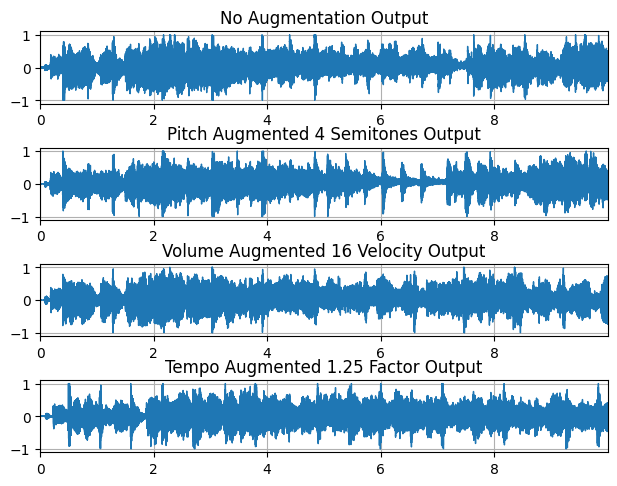

In [16]:
fig, axs = plt.subplots(4, 1)
fig.tight_layout()
plot_waveform(normal_output, normal_sr, title="No Augmentation Output", ax=axs[0])
plot_waveform(pitch_output, pitch_sr, title=f"Pitch Augmented {pitch_value} Semitones Output", ax=axs[1])
plot_waveform(vol_output, vol_sr, title=f"Volume Augmented {vol_value} Velocity Output", ax=axs[2])
plot_waveform(tempo_output, tempo_sr, title=f"Tempo Augmented {tempo_value} Factor Output", ax=axs[3])

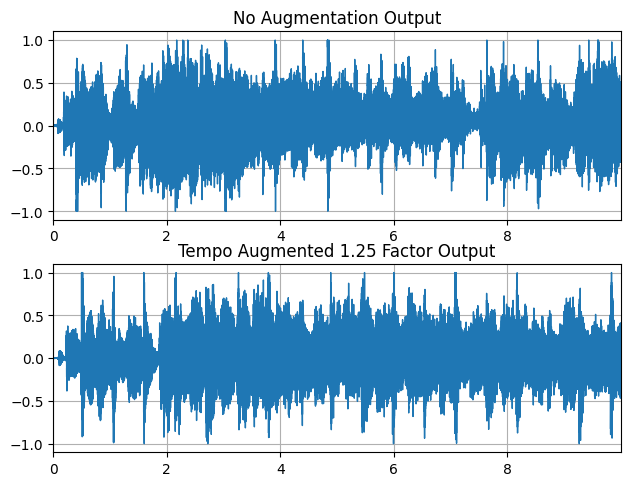

In [17]:
# compare normal output with the tempo augmentation output for all 10 second
# calculate the root mean squared error between them
original_tempo_rmse = F.mse_loss(normal_output, tempo_output).sqrt()

fig, axs = plt.subplots(2, 1)
fig.tight_layout()
plot_waveform(normal_output, normal_sr, title="No Augmentation Output", ax=axs[0])
plot_waveform(tempo_output, tempo_sr, title=f"Tempo Augmented {tempo_value} Factor Output", ax=axs[1])

160000


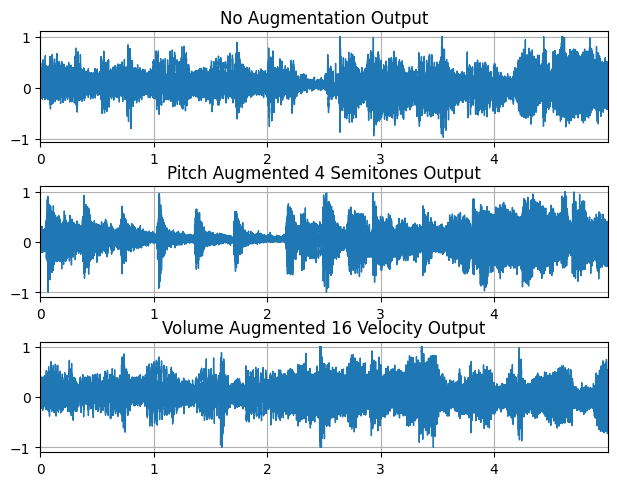

In [18]:
# prompt duration set as first 5 seconds so we trim and only look at later 5 sec
halfway = int(normal_output.size(1) / 2)
print(halfway)
normal_output = normal_output[:, halfway:]
pitch_output = pitch_output[:, halfway:]
vol_output = vol_output[:, halfway:]

original_pitch_rmse = F.mse_loss(normal_output, pitch_output).sqrt()
original_vol_rmse = F.mse_loss(normal_output, vol_output).sqrt()

fig, axs = plt.subplots(3, 1)
fig.tight_layout()
plot_waveform(normal_output, normal_sr, title="No Augmentation Output", ax=axs[0])
plot_waveform(pitch_output, pitch_sr, title=f"Pitch Augmented {pitch_value} Semitones Output", ax=axs[1])
plot_waveform(vol_output, vol_sr, title=f"Volume Augmented {vol_value} Velocity Output", ax=axs[2])

In [19]:
print(original_pitch_rmse)
print(original_vol_rmse)
print(original_tempo_rmse)

tensor(0.2589)
tensor(0.2796)
tensor(0.2902)


In [20]:
file_numbers = file_mapping.keys()

original_pitch_rmses = []
original_vol_rmses = []
original_tempo_rmses = []

for i in file_numbers:
  if len(file_mapping[str(i)]) == 4:
    normal_filepath = file_mapping[str(i)]['original']
    pitch_filepath = file_mapping[str(i)]['pitch']
    vol_filepath = file_mapping[str(i)]['vol']
    tempo_filepath = file_mapping[str(i)]['tempo']

    normal_output, normal_sr = torchaudio.load(normal_filepath)
    pitch_output, pitch_sr = torchaudio.load(pitch_filepath)
    vol_output, vol_sr = torchaudio.load(vol_filepath)
    tempo_output, tempo_sr = torchaudio.load(tempo_filepath)

    # ensure they all have the same sampling rate
    assert normal_sr == pitch_sr == vol_sr == tempo_sr

    # ensure they all waveforms have the same length
    assert normal_output.size(1) == pitch_output.size(1) == vol_output.size(1) == tempo_output.size(1)

    # normalize the waveforms
    normal_output /= normal_output.abs().max()
    pitch_output /= pitch_output.abs().max()
    vol_output /= vol_output.abs().max()
    tempo_output /= tempo_output.abs().max()

    # calculate root mean squared error between normal output and tempo
    original_tempo_rmses.append(F.mse_loss(normal_output, tempo_output).sqrt())

    # for volume and augmentation we trim off the prompt b/c they are the same as the normal output
    halfway = int(normal_output.size(1) / 2)
    normal_output = normal_output[:, halfway:]
    pitch_output = pitch_output[:, halfway:]
    vol_output = vol_output[:, halfway:]
    original_vol_rmses.append(F.mse_loss(normal_output, vol_output).sqrt())
    original_pitch_rmses.append(F.mse_loss(normal_output, pitch_output).sqrt())

# average all three lists of rmses
original_pitch_avg = sum(original_pitch_rmses) / len(original_pitch_rmses)
original_vol_avg = sum(original_vol_rmses) / len(original_vol_rmses)
original_tempo_avg = sum(original_tempo_rmses) / len(original_tempo_rmses)
print(f"The average root mean squared error loss between the original and pitch augmented outputs are {original_pitch_avg}")
print(f"The average root mean squared error loss between the original and volume augmented outputs are {original_vol_avg}")
print(f"The average root mean squared error loss between the original and tempo augmented outputs are {original_tempo_avg}")

The average root mean squared error loss between the original and pitch augmented outputs are 0.3127136528491974
The average root mean squared error loss between the original and volume augmented outputs are 0.3104439377784729
The average root mean squared error loss between the original and tempo augmented outputs are 0.2935928404331207
